In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# visualization library
import seaborn as sns

In [2]:
df = pd.read_csv("df_Preprocessed2.csv")
df=df.drop(['dteday'], axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,cluster
0,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,low
1,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,low
2,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,low
3,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,low
4,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,low


## Train and Test set Splitting

In [37]:
from sklearn.model_selection import train_test_split

feature_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_cols]
y = df.cluster
yReg= df.cnt

#Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(X, yReg, test_size=0.25, random_state=42)

print("Train size",X_train.shape[0])
print("Test size", len(X_test))

Train size 548
Test size 183


## Model creation

In [38]:
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#score df is later used for comparison between differen iteration
score_df = pd.DataFrame(columns=["method"])


def  My_Classifier (X_train, y_train, X_test, y_test,it=0):
    col="score "+str(it)
    score_df[col]=0.0
    maxScore =0
    
    
    logreg = LogisticRegression()
    clf=RandomForestClassifier(n_estimators=1000)
    nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
    
    #fit
    logreg.fit(X_train, y_train)
    clf.fit(X_train,y_train)
    nn.fit(X_train, y_train)   

    #Score
    score=logreg.score(X_test,y_test)
    score_df.at[0,'method'] = "Logistic Regression"
    score_df.at[0,col] = score
    
    score=clf.score(X_test,y_test)
    score_df.at[1,'method'] = "Random Forest"
    score_df.at[1,col] = score
    
    score=nn.score(X_test,y_test)
    score_df.at[2,'method'] = "Neural Network"
    score_df.at[2,col] = score

    
    #Score for K-Neigh
    for n in range (1,100):
        neigh = KNeighborsClassifier(n_neighbors=n)
        neigh.fit(X_train, y_train) 
        if maxScore < neigh.score(X_test,y_test):
            n1 = n
            maxScore = neigh.score(X_test,y_test)

    score_df.at[3,'method'] = "K-Neighbors"
    score_df.at[3,col] = maxScore
    
My_Classifier (X_train, y_train,X_test, y_test,0)

In [39]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


def  My_Regression (X_train, y_train, X_test, y_test,it=0):
    col="score "+str(it)
    
    reg = LinearRegression()
    reg.fit(X_train,y_train)

    y_predicted = reg.predict(X_test)
    score_df.at[4,'method'] = 'Linear Regression'
    score_df.at[4,col] = r2_score(y_test, y_predicted)

My_Regression(X_trainReg, y_trainReg,X_testReg, y_testReg)

In [40]:
def print_result(it=0):
    #print(score_df)
    for i,row in score_df.iterrows():
        print (row[0], row[it+1])
print_result()

Logistic Regression 0.8524590163934426
Random Forest 0.912568306010929
Neural Network 0.8688524590163934
K-Neighbors 0.8797814207650273
Linear Regression 0.8158954153942367


# Feature selection

In [7]:
feature_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = df.loc[:, feature_cols]
y = df.cluster

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 8 best features
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

         Specs      Score
1           yr  95.836530
2         mnth  56.264974
0       season  31.621979
7         temp  10.982432
6   weathersit   8.975410
8        atemp   8.965428
4      weekday   4.769685
10   windspeed   0.622985
3      holiday   0.471047
9          hum   0.410661


[0.10378306 0.26669417 0.09278584 0.00520371 0.04772484 0.01571201
 0.05245128 0.13072706 0.16823801 0.06216498 0.05451503]


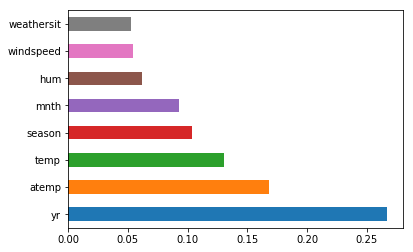

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

# Prediction using most effective features

In [41]:
import warnings; warnings.simplefilter('ignore')

#feature_cols = ['instant','season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
features1=['mnth','yr','season','temp','hum','weathersit','windspeed']
X = df.loc[:, features1]
y = df.cluster

#Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(X, yReg, test_size=0.25, random_state=42)

My_Classifier(X_train, y_train,X_test, y_test, 1)

My_Regression(X_trainReg, y_trainReg,X_testReg, y_testReg,1)

In [42]:
print_result(1)


Logistic Regression 0.8633879781420765
Random Forest 0.9180327868852459
Neural Network 0.8879617486338798
K-Neighbors 0.9234972677595629
Linear Regression 0.8266889860830545


# Results comparison

In [44]:
score_df

,method,score 0,score 1
0,Logistic Regression,0.852459,0.863388
1,Random Forest,0.912568,0.918033
2,Neural Network,0.868852,0.887962
3,K-Neighbors,0.879781,0.923497
4,Linear Regression,0.815895,0.826689


# Parameter Tuning for Neural Network 

In [16]:
mlp = MLPClassifier(max_iter=100)

In [17]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [18]:
parameters = {'solver': ['lbfgs'], 'max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}


In [19]:
nn= MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes= (50, 100, 50), learning_rate= 'constant', solver='adam')
nn.fit(X_train, y_train)
score=nn.score(X_test,y_test)
print('Neural Network: ', score)

Neural Network:  0.9016393442622951
